In [38]:
!pip install fastf1


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import fastf1
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fastf1
from fastf1 import plotting
import requests
import fastf1.plotting
import seaborn as sns
from matplotlib import colormaps
from matplotlib.collections import LineCollection
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import psycopg2
from matplotlib import cm
print(fastf1.__version__)

3.6.0


In [34]:
class FastF1:
    def __init__(self, year, event_name, session_type):
        """
        Initializes the FastF1 object by retrieving the session for the given year, event, and session type.
        
        Args:
            year (int): The year of the event.
            event_name (str): The name of the event (e.g., 'Belgium').
            session_type (str): The session type (e.g., 'Q' for qualifying, 'R' for race).
        """
        self.year = year
        self.session = fastf1.get_session(year, event_name, session_type)
        self.laps = None

    def load_session(self):
        """
        Loads the session data into memory and stores the laps DataFrame.
        """
        self.session.load()
        self.laps = self.session.laps

    def session_event(self):
        """
        Returns the event information object for the loaded session.
        
        Returns:
            fastf1.core.Event: Event object containing details about the loaded session.
        """
        return self.session.event

    def lap_info(self):
        """
        Provides a summary info of the laps DataFrame including column data types and non-null counts.
        
        Returns:
            str: Output of DataFrame.info() for laps.
        """
        return self.laps.info()

    def fastest_lap(self):
        """
        Retrieves the fastest lap from the loaded laps DataFrame.
        
        Returns:
            fastf1.core.Lap: The fastest lap object in the session.
        """
        return self.laps.pick_fastest()

    def value_count(self):
        """
        Counts laps grouped by tyre compound used in the session.
        
        Returns:
            pandas.Series: Counts of laps per tyre compound.
        """
        df = self.session.laps
        return df['Compound'].value_counts()

    def stint_analysis(self):
        """
        Counts the number of laps per driver per stint by grouping on 'Driver' and 'Stint'.
        
        Returns:
            pandas.Series: Number of laps grouped by driver and stint.
        """
        return self.laps.groupby(['Driver', 'Stint'])['LapNumber'].count()

    def null_percent(self):
        """
        Calculates the percentage of null values for each column in the laps DataFrame.
        
        Returns:
            pandas.Series: Percentage of null values per column.
        """
        null_percent = self.laps.isnull().mean() * 100
        return null_percent

    def sector_time_comparison(self):
        """
        Retrieves the fastest sector times (Sector 1, 2, and 3) in seconds for each driver, sorted by Sector 1.
        
        Returns:
            pandas.DataFrame: Fastest sector times per driver in seconds, sorted ascending by Sector 1 time.
        """
        df = self.session.laps
        fastest = df.groupby('Driver')[['Sector1Time', 'Sector2Time', 'Sector3Time']].min()
        fastest = fastest.apply(lambda x: x.dt.total_seconds())
        return fastest.sort_values(by='Sector1Time')

    def avg_laptime(self):
        """
        Calculates the average lap time for each driver in seconds.
        
        Returns:
            pandas.Series: Average lap times by driver sorted from fastest to slowest.
        """
        df = self.session.laps
        avg_laptime = df.groupby('Driver')['LapTime'].mean()
        avg_laptime = avg_laptime.apply(lambda x: x.total_seconds())
        return avg_laptime.sort_values()

    def fastest_laptime(self):
        """
        Calculates the fastest lap time for each driver (and team) in seconds.
        
        Returns:
            pandas.Series: Fastest lap times per driver and team, sorted ascending.
        """
        df = self.session.laps
        min_laptime = df.groupby(['Driver', 'Team'])['LapTime'].min()
        min_laptime_seconds = min_laptime.apply(lambda x: x.total_seconds())
        return min_laptime_seconds.sort_values()

    def pit_stop_count(self):
        """
        Counts the number of pit stops made by each driver during the session.
        
        Returns:
            pandas.Series: Number of pit stops per driver sorted ascending.
        """
        df = self.session.laps
        pit_counts = df[df['PitInTime'].notna()].groupby('Driver')['PitInTime'].count()
        return pit_counts.sort_values()

    def compound_data(self):
        """
        Filters laps for tyre compounds 'SOFT', 'MEDIUM', and 'HARD' and returns related columns.
        
        Returns:
            pandas.DataFrame: DataFrame with columns ['Compound', 'TyreLife', 'FreshTyre'] for specified compounds.
        """
        return self.laps[self.laps['Compound'].isin(['SOFT', 'MEDIUM', 'HARD'])][['Compound', 'TyreLife', 'FreshTyre']]

    def plot_tyre_life_distribution(self):
        """
        Plots a boxplot to show the distribution of tyre life for each compound ('SOFT', 'MEDIUM', 'HARD').
        """
        data = self.compound_data()
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=data, x='Compound', y='TyreLife', palette='coolwarm')
        plt.title('Tyre Life Distribution by Compound')
        plt.ylabel('Tyre Life (laps)')
        plt.xlabel('Tyre Compound')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_avg_tyre_life(self):
        """
        Plots a bar chart showing the average tyre life for each tyre compound.
        """
        avg_life = self.laps.groupby('Compound')['TyreLife'].mean().reset_index()
        plt.figure(figsize=(8, 5))
        sns.barplot(data=avg_life, x='Compound', y='TyreLife', palette='Set2')
        plt.title('Average Tyre Life by Compound')
        plt.ylabel('Average Tyre Life (laps)')
        plt.xlabel('Tyre Compound')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_fresh_vs_used_tyres(self):
        """
        Plots a stacked bar chart comparing counts of fresh versus used tyres for each compound.
        """
        compound_fresh_counts = self.laps.groupby(['Compound', 'FreshTyre']).size().unstack(fill_value=0)
        compound_fresh_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
        plt.title('Fresh vs Used Tyres per Compound')
        plt.xlabel('Tyre Compound')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Fresh Tyre (1=Fresh, 0=Used)')
        plt.tight_layout()
        plt.show()

    def driver_position_chart(self):
        """
        Plots the position changes of each driver over laps during the session.
        The Y-axis is inverted so that position 1 is at the top.
        """
        df = self.session.laps
        df = df[df['Position'].notnull()]
        plt.figure(figsize=(12, 6))

        for driver in df['Driver'].unique():
            driver_data = df[df['Driver'] == driver]
            plt.plot(driver_data['LapNumber'], driver_data['Position'], label=driver)
            plt.text(driver_data['LapNumber'].iloc[-1] + 0.2, driver_data['Position'].iloc[-1], driver,
                     verticalalignment='center')

        plt.gca().invert_yaxis()
        plt.xlabel("Lap")
        plt.ylabel("Position")
        plt.title(f"{self.session.event['EventName']} {self.year} - Position Changes")
        plt.tight_layout()
        plt.show()

    def compare_speed_overlay(self, driver1, driver2):
        """
        Plots an overlay comparison of speed vs distance for the fastest laps of two drivers.
        
        Args:
            driver1 (str): Driver code of the first driver.
            driver2 (str): Driver code of the second driver.
        """
        lap1 = self.session.laps.pick_drivers(driver1).pick_fastest()
        lap2 = self.session.laps.pick_drivers(driver2).pick_fastest()

        tel1 = lap1.get_car_data().add_distance()
        tel2 = lap2.get_car_data().add_distance()

        plt.figure(figsize=(12, 6))
        plt.plot(tel1['Distance'], tel1['Speed'], label=driver1)
        plt.plot(tel2['Distance'], tel2['Speed'], label=driver2)
        plt.xlabel('Distance (m)')
        plt.ylabel('Speed (km/h)')
        plt.title(f"Speed Comparison: {driver1} vs {driver2}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_fastest_lap_gear_shifts(self):
        """
        Plots the racing line of the fastest lap on the track colored by gear shifts.
        """
        lap = self.session.laps.pick_fastest()
        tel = lap.get_telemetry()
        x = np.array(tel['X'].values)
        y = np.array(tel['Y'].values)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        gear = tel['nGear'].to_numpy().astype(float)
        cmap = cm.get_cmap('Paired')
        lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
        lc_comp.set_array(gear)
        lc_comp.set_linewidth(4)
        plt.figure(figsize=(12, 8))
        plt.gca().add_collection(lc_comp)
        plt.axis('equal')
        plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
        plt.suptitle(
            f"Fastest Lap Gear Shift Visualization\n"
            f"{lap['Driver']} - {self.session.event['EventName']} {self.session.event.year}"
        )
        cbar = plt.colorbar(mappable=lc_comp, label="Gear", boundaries=np.arange(1, 10))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(np.arange(1, 9))
        plt.show()

    def plot_driver_fastest_lap_speed(self, driver, colormap='viridis', weekend_name=None):
        """
        Plots the fasting lap racing line for a driver colored by speed.

        Args:
            driver (str): Driver code (e.g., 'VER').
            colormap (str): Name of the matplotlib colormap to use.
            weekend_name (str, optional): Weekend or event name for the plot title.
        """
        lap = self.session.laps.pick_drivers(driver).pick_fastest()
        tel = lap.telemetry
        x = tel['X'].values
        y = tel['Y'].values
        color = tel['Speed'].values
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        fig, ax = plt.subplots(figsize=(12, 6.75))
        title_str = f'{weekend_name or self.session.event["EventName"]} {self.year} - {driver} - Speed'
        fig.suptitle(title_str, size=24, y=0.97)

        ax.plot(x, y, color='black', linewidth=16, zorder=0)

        norm = plt.Normalize(color.min(), color.max())
        lc = LineCollection(segments, cmap=plt.get_cmap(colormap), norm=norm, linewidth=5)
        lc.set_array(color)
        ax.add_collection(lc)

        cbar = plt.colorbar(lc, ax=ax, orientation='horizontal', pad=0.1)
        cbar.set_label('Speed (km/h)')
        ax.axis('off')
        plt.show()


        
    @staticmethod
    def pg_type_from_dtype(dtype_str):
        """Maps pandas dtype to PostgreSQL type"""
        if 'int' in dtype_str:
            return 'INTEGER'
        elif 'float' in dtype_str:
            return 'FLOAT'
        elif 'datetime' in dtype_str:
            return 'TIMESTAMP'
        elif 'bool' in dtype_str:
            return 'BOOLEAN'
        else:
            return 'TEXT'

    def create_table_if_not_exists(self, db_params, table_name="fastf1_data"):
        """
        Creates a PostgreSQL table for laps data if it doesn't exist.
        Converts timedelta columns to FLOAT (seconds).
        """
        laps_df = self.laps.copy()

        # Convert timedelta -> seconds (float)
        for col in laps_df.select_dtypes(include=["timedelta"]).columns:
            laps_df[col] = laps_df[col].dt.total_seconds()

        columns = []
        for col in laps_df.columns:
            dtype = str(laps_df[col].dtype)
            pg_type = self.pg_type_from_dtype(dtype)
            columns.append(f'"{col}" {pg_type}')

        create_stmt = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            {", ".join(columns)}
        )
        """

        conn = psycopg2.connect(**db_params)
        cur = conn.cursor()
        cur.execute(create_stmt)
        conn.commit()
        cur.close()
        conn.close()

    def insert_laps_to_postgres(self, db_params, table_name="fastf1_data"):
        """
        Inserts the laps dataframe into a PostgreSQL table.
        """
        # Ensure table exists
        self.create_table_if_not_exists(db_params, table_name)

        laps_df = self.laps.copy()

        # Convert timedelta -> seconds (float)
        for col in laps_df.select_dtypes(include=["timedelta"]).columns:
            laps_df[col] = laps_df[col].dt.total_seconds()

        laps_df = laps_df.replace({np.nan: None, pd.NaT: None})
        columns = list(laps_df.columns)
        placeholders = ', '.join(['%s'] * len(columns))

        insert_stmt = f"""
        INSERT INTO {table_name} ({', '.join([f'"{col}"' for col in columns])})
        VALUES ({placeholders})
        """

        conn = psycopg2.connect(**db_params)
        cur = conn.cursor()
        for _, row in laps_df.iterrows():
            row_values = [None if pd.isna(val) else val for val in row]
            cur.execute(insert_stmt, tuple(row_values))

        conn.commit()
        cur.close()
        conn.close()

In [3]:
f1 = FastF1(2023, 'Belgium', 'R')

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\hi\AppData\Local\Temp\fastf1


In [4]:
f1.load_session()

core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

In [5]:
f1.laps  # LapsDataFrame with all lap details

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:04:40.474000,VER,1,0 days 00:01:55.659000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:49.787000,...,True,Red Bull Racing,0 days 01:02:44.614000,2023-07-30 13:03:45.833,1,4.0,False,,False,False
1,0 days 01:06:33.577000,VER,1,0 days 00:01:53.103000,2.0,1.0,NaT,NaT,0 days 00:00:32.291000,0 days 00:00:50.712000,...,True,Red Bull Racing,0 days 01:04:40.474000,2023-07-30 13:05:41.693,12,4.0,False,,False,True
2,0 days 01:08:25.854000,VER,1,0 days 00:01:52.277000,3.0,1.0,NaT,NaT,0 days 00:00:31.758000,0 days 00:00:50.325000,...,True,Red Bull Racing,0 days 01:06:33.577000,2023-07-30 13:07:34.796,21,4.0,False,,False,True
3,0 days 01:10:18.643000,VER,1,0 days 00:01:52.789000,4.0,1.0,NaT,NaT,0 days 00:00:31.881000,0 days 00:00:50.599000,...,True,Red Bull Racing,0 days 01:08:25.854000,2023-07-30 13:09:27.073,1,4.0,False,,False,True
4,0 days 01:12:11.245000,VER,1,0 days 00:01:52.602000,5.0,1.0,NaT,NaT,0 days 00:00:32.001000,0 days 00:00:50.201000,...,True,Red Bull Racing,0 days 01:10:18.643000,2023-07-30 13:11:19.862,1,4.0,False,,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,0 days 01:41:37.186000,SAI,55,0 days 00:01:56.426000,20.0,2.0,NaT,NaT,0 days 00:00:32.648000,0 days 00:00:52.419000,...,True,Ferrari,0 days 01:39:40.760000,2023-07-30 13:40:41.979,1,19.0,False,,False,True
812,0 days 01:43:37.348000,SAI,55,0 days 00:02:00.162000,21.0,2.0,NaT,NaT,0 days 00:00:32.787000,0 days 00:00:54.760000,...,True,Ferrari,0 days 01:41:37.186000,2023-07-30 13:42:38.405,1,19.0,True,TRACK LIMITS AT TURN 11 LAP 21,False,True
813,0 days 01:45:35.297000,SAI,55,0 days 00:01:57.949000,22.0,2.0,NaT,NaT,0 days 00:00:32.936000,0 days 00:00:53.638000,...,True,Ferrari,0 days 01:43:37.348000,2023-07-30 13:44:38.567,1,19.0,False,,False,True
814,0 days 01:47:38.660000,SAI,55,0 days 00:02:03.363000,23.0,2.0,NaT,0 days 01:47:34.913000,0 days 00:00:32.748000,0 days 00:00:52.157000,...,True,Ferrari,0 days 01:45:35.297000,2023-07-30 13:46:36.516,1,19.0,False,,False,False


In [6]:
print(f1.session_event())  # Prints event details

RoundNumber                                                     12
Country                                                    Belgium
Location                                         Spa-Francorchamps
OfficialEventName    FORMULA 1 MSC CRUISES BELGIAN GRAND PRIX 2023
EventDate                                      2023-07-30 00:00:00
EventName                                       Belgian Grand Prix
EventFormat                                        sprint_shootout
Session1                                                Practice 1
Session1Date                             2023-07-28 13:30:00+02:00
Session1DateUtc                                2023-07-28 11:30:00
Session2                                                Qualifying
Session2Date                             2023-07-28 17:00:00+02:00
Session2DateUtc                                2023-07-28 15:00:00
Session3                                           Sprint Shootout
Session3Date                             2023-07-29 12:00:00+0

In [7]:
f1.lap_info()

<class 'fastf1.core.Laps'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   Time                816 non-null    timedelta64[ns]
 1   Driver              816 non-null    object         
 2   DriverNumber        816 non-null    object         
 3   LapTime             815 non-null    timedelta64[ns]
 4   LapNumber           816 non-null    float64        
 5   Stint               816 non-null    float64        
 6   PitOutTime          38 non-null     timedelta64[ns]
 7   PitInTime           38 non-null     timedelta64[ns]
 8   Sector1Time         796 non-null    timedelta64[ns]
 9   Sector2Time         815 non-null    timedelta64[ns]
 10  Sector3Time         815 non-null    timedelta64[ns]
 11  Sector1SessionTime  796 non-null    timedelta64[ns]
 12  Sector2SessionTime  815 non-null    timedelta64[ns]
 13  Sector3SessionTime  815 non-null    timedelta6

In [8]:
f1.fastest_lap()

Time                      0 days 02:26:04.936000
Driver                                       HAM
DriverNumber                                  44
LapTime                   0 days 00:01:47.305000
LapNumber                                   44.0
Stint                                        4.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:31.545000
Sector2Time               0 days 00:00:46.470000
Sector3Time               0 days 00:00:29.290000
Sector1SessionTime        0 days 02:24:49.236000
Sector2SessionTime        0 days 02:25:35.706000
Sector3SessionTime        0 days 02:26:04.996000
SpeedI1                                    311.0
SpeedI2                                    197.0
SpeedFL                                    217.0
SpeedST                                    309.0
IsPersonalBest                              True
Compound                                  MEDIUM
TyreLife            

In [9]:
f1.value_count()

Compound
MEDIUM    419
SOFT      385
HARD       12
Name: count, dtype: int64

In [10]:
f1.stint_analysis()

Driver  Stint
ALB     1.0       7
        2.0      16
        3.0      10
        4.0      11
ALO     1.0      10
        2.0      19
        3.0      15
BOT     1.0       6
        2.0      18
        3.0      20
GAS     1.0      23
        2.0      21
HAM     1.0      12
        2.0      15
        3.0      15
        4.0       2
HUL     1.0      12
        2.0      12
        3.0      20
LEC     1.0      13
        2.0      15
        3.0      16
MAG     1.0       5
        2.0      20
        3.0      19
NOR     1.0       5
        2.0      12
        3.0      27
OCO     1.0       6
        2.0      19
        3.0      19
PER     1.0      13
        2.0      16
        3.0      15
PIA     1.0       1
RIC     1.0       5
        2.0      17
        3.0      22
RUS     1.0      22
        2.0      22
SAI     1.0       7
        2.0      16
SAR     1.0       8
        2.0      16
        3.0      10
        4.0      10
STR     1.0      20
        2.0      24
TSU     1.0       9
      

In [11]:
f1.null_percent()

Time                   0.000000
Driver                 0.000000
DriverNumber           0.000000
LapTime                0.122549
LapNumber              0.000000
Stint                  0.000000
PitOutTime            95.343137
PitInTime             95.343137
Sector1Time            2.450980
Sector2Time            0.122549
Sector3Time            0.122549
Sector1SessionTime     2.450980
Sector2SessionTime     0.122549
Sector3SessionTime     0.122549
SpeedI1               11.029412
SpeedI2                0.122549
SpeedFL                4.779412
SpeedST               17.769608
IsPersonalBest         0.000000
Compound               0.000000
TyreLife               0.000000
FreshTyre              0.000000
Team                   0.000000
LapStartTime           0.000000
LapStartDate           0.000000
TrackStatus            0.000000
Position               0.122549
Deleted                0.000000
DeletedReason          0.000000
FastF1Generated        0.000000
IsAccurate             0.000000
dtype: f

In [12]:
f1.avg_laptime()

Driver
VER    112.510227
PER    113.017159
LEC    113.243386
HAM    113.639113
ALO    113.787136
RUS    113.944340
NOR    114.185659
OCO    114.208386
STR    114.313409
TSU    114.333431
GAS    114.398500
BOT    114.446386
ZHO    114.679340
ALB    114.696227
MAG    114.822818
RIC    114.852750
SAR    114.884681
HUL    115.020454
SAI    117.123695
PIA           NaN
Name: LapTime, dtype: float64

In [13]:
f1.fastest_laptime()

Driver  Team           
HAM     Mercedes           107.305
VER     Red Bull Racing    108.922
ALB     Williams           109.841
HUL     Haas F1 Team       109.907
ZHO     Alfa Romeo         110.188
SAR     Williams           110.236
PER     Red Bull Racing    110.308
LEC     Ferrari            110.436
OCO     Alpine             110.439
BOT     Alfa Romeo         110.515
RUS     Mercedes           110.603
GAS     Alpine             110.911
ALO     Aston Martin       110.938
MAG     Haas F1 Team       110.993
RIC     AlphaTauri         110.994
STR     Aston Martin       111.297
TSU     AlphaTauri         111.394
NOR     McLaren            111.682
SAI     Ferrari            113.138
PIA     McLaren                NaN
Name: LapTime, dtype: float64

In [14]:
f1.sector_time_comparison()

,Sector1Time,Sector2Time,Sector3Time
Driver,,,
OCO,31.249,48.604,30.005
HUL,31.307,48.733,29.867
ALB,31.336,48.936,29.513
SAR,31.404,48.766,29.566
GAS,31.455,49.224,29.858
HAM,31.545,46.470,29.290
RIC,31.555,49.417,30.022
ZHO,31.560,48.488,29.771
RUS,31.572,48.639,29.894


In [15]:
f1.pit_stop_count()

Driver
GAS    1
STR    1
RUS    1
ALO    2
MAG    2
LEC    2
BOT    2
HUL    2
RIC    2
PER    2
NOR    2
OCO    2
SAI    2
ZHO    2
VER    2
TSU    2
SAR    3
HAM    3
ALB    3
Name: PitInTime, dtype: int64

In [16]:
f1.compound_data()

,Compound,TyreLife,FreshTyre
0,SOFT,1.0,True
1,SOFT,2.0,True
2,SOFT,3.0,True
3,SOFT,4.0,True
4,SOFT,5.0,True
...,...,...,...
811,MEDIUM,13.0,True
812,MEDIUM,14.0,True
813,MEDIUM,15.0,True
814,MEDIUM,16.0,True


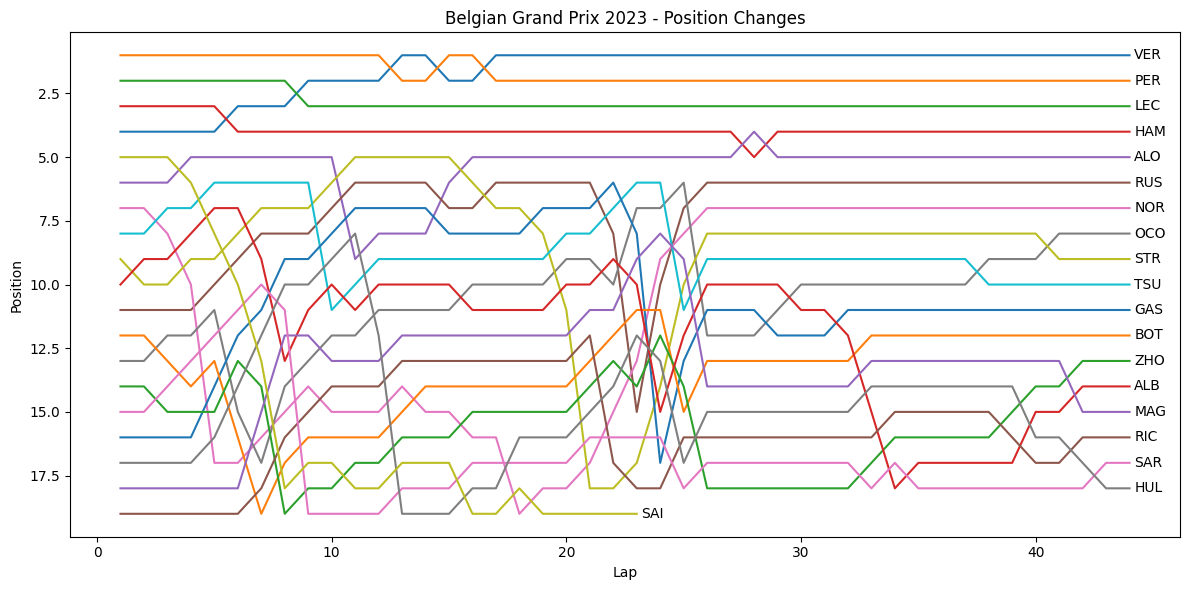

In [17]:
f1.driver_position_chart()

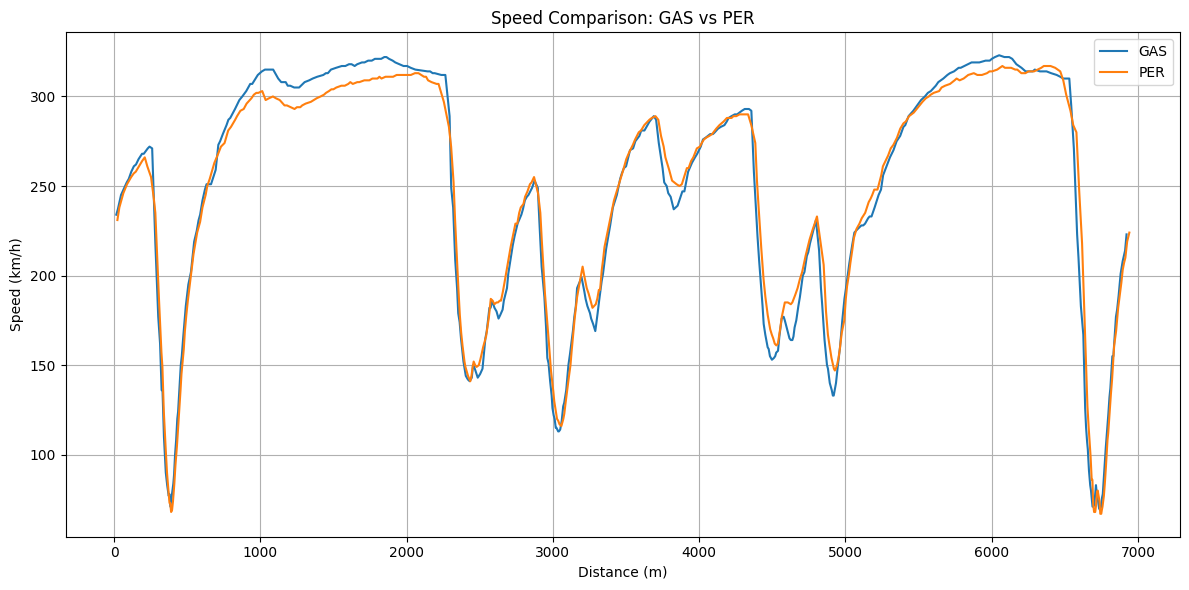

In [18]:
f1.compare_speed_overlay("GAS","PER")

C:\Users\hi\AppData\Local\Temp\ipykernel_25376\2494632626.py:236: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Paired')


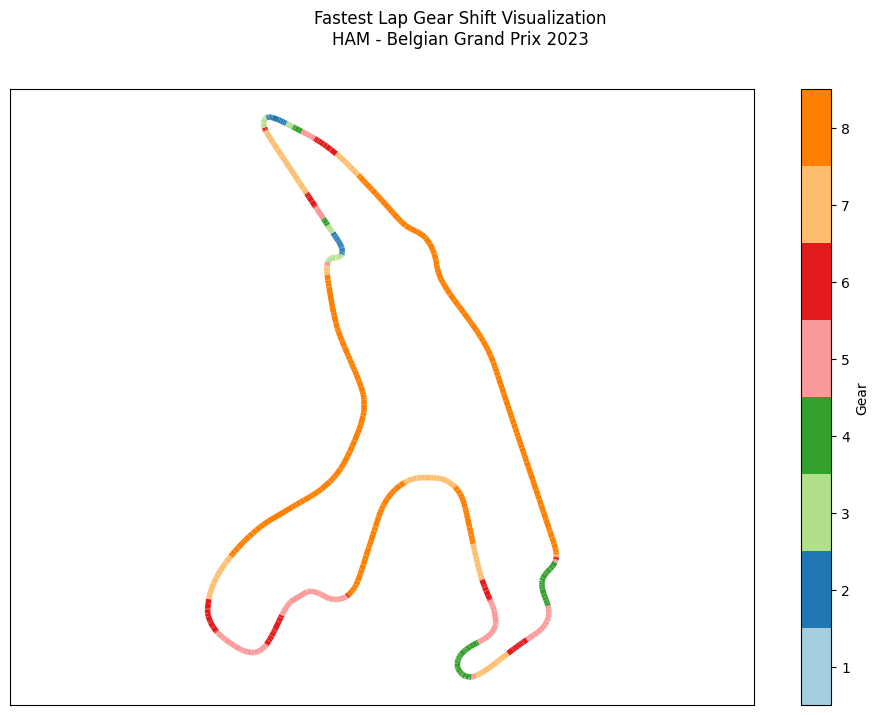

In [19]:
f1.plot_fastest_lap_gear_shifts() # Fastest lap gear shift visualization

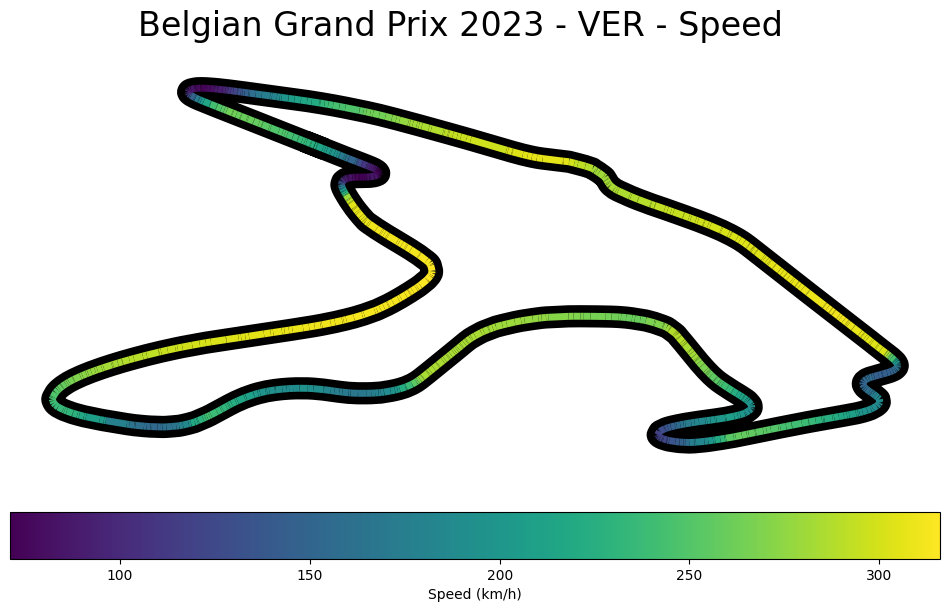

In [20]:
f1.plot_driver_fastest_lap_speed('VER')

C:\Users\hi\AppData\Local\Temp\ipykernel_25376\2494632626.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Compound', y='TyreLife', palette='coolwarm')


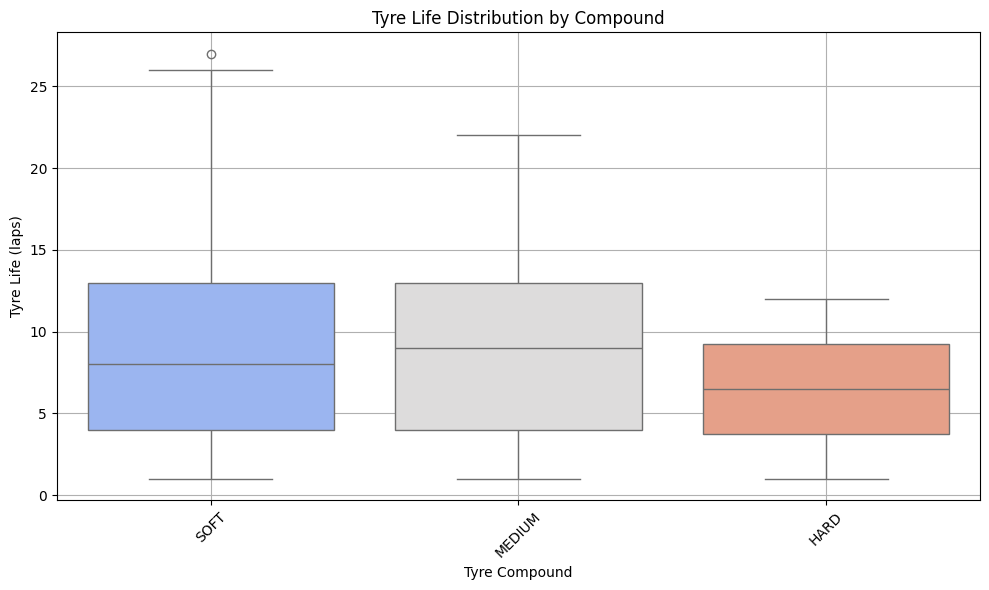

In [21]:
f1.plot_tyre_life_distribution()

C:\Users\hi\AppData\Local\Temp\ipykernel_25376\2494632626.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_life, x='Compound', y='TyreLife', palette='Set2')


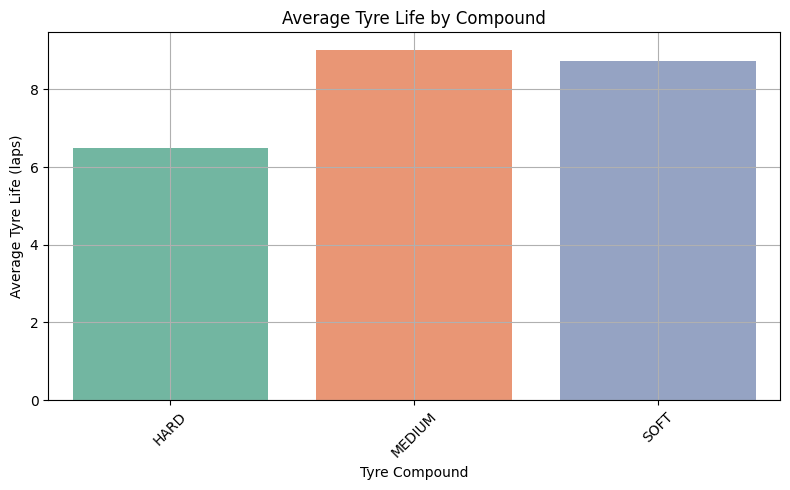

In [22]:
f1.plot_avg_tyre_life()

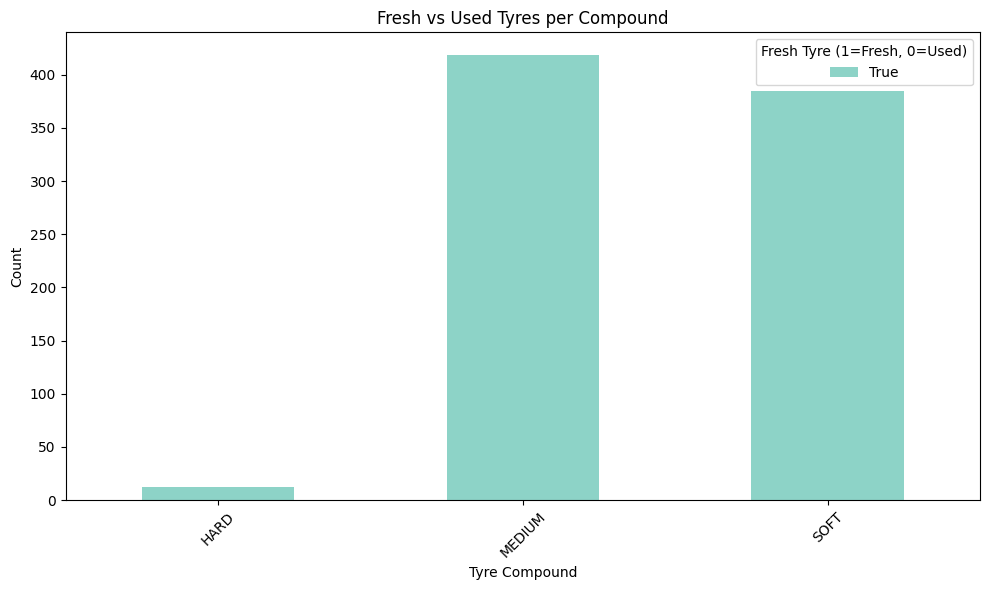

In [23]:
f1.plot_fresh_vs_used_tyres()

In [24]:
f1.pg_type_from_dtype('dtype_str')

'TEXT'

In [37]:
db_params = {
    "dbname": "postgres",
    "user": "postgres",
    "password": "901473R",
    "host": "localhost",
    "port": "5432"
}

f1 = FastF1(2023, "Monaco", "R")  # Example
f1.load_session()
f1.insert_laps_to_postgres(db_params)


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cac